In [18]:
import pandas as pd
import glob
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community.community_louvain
import community
from collections import Counter

In [58]:
# remove later
marinas_path = '/Users/mep/Desktop/mep/SocialGraphs/FriendsSentimentAnalysis/episodes'

In [2]:
# remove later
# stella add your path here!!
stellas_path = r'C:\Users\stykaly\OneDrive - DFDS\Documents\GitHub\FriendsSentimentAnalysis\scripts'

In [3]:
# change according to who's working
episodes_path = stellas_path

In [4]:
#input each apisode into a list of str , returns dictionary with episode no as key and script string a value
def make_season_dictionary(episodes_path):
    season_episodes={}
    list_of_episodes = os.listdir( episodes_path)
    for episode in range(228):  # ONLY FOR 1ST SEASON!!
        text_file = open(episodes_path+"/"+list_of_episodes[episode], "r",encoding='utf8')
        episode_script = text_file.read()
        text_file.close()
        season_episodes['{}'.format(f'episode{episode}')]=episode_script
    return season_episodes
    #print(season_episodes)
    
season_dictionary=make_season_dictionary(episodes_path)


In [5]:
#takes a str and splits on Scene, returns list of scenes
def split_episode_scenes(episode_script):
    scenes_of_episode = re.split(r'\[Scene:',episode_script)
    return scenes_of_episode


# takes list as input and extracts list of locations
def locations_finder(scenes_of_episode):
    location_list = []
    for scene in range(1,len(scenes_of_episode)):
        scenes_of_episode[scene]= re.sub(r';',r',',  scenes_of_episode[scene])
        scenes_of_episode[scene]= scenes_of_episode[scene].lower()
        scenes_of_episode[scene]= re.sub(r'rach',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'mnca',r'monica',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chan',r'chandler',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoebebe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'estl',r'estelle',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'rachelel',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chandlerdler',r'chandler',  scenes_of_episode[scene])
        location = scenes_of_episode[scene].partition(",")[0]
        location_list.append(location)
    return location_list

#takes list as input and extracts list of lists of names of characters, removes duplicates
def character_finder(scenes_of_episode):
    characters_of_scene_list = []
    for scene in range(1,len(scenes_of_episode)):
        character= re.findall('\n[a-zA-Z]+\:',scenes_of_episode[scene])
        for i in range (len(character)):
            character[i] = re.sub(r'\n',r'',character[i])
            character[i] = re.sub(r':',r'',character[i])
        characters_of_scene_list.append(character)
    for scene in range (len(characters_of_scene_list)):
        characters_of_scene_list[scene]= list(dict.fromkeys(characters_of_scene_list[scene]))
    return characters_of_scene_list


In [6]:
##creates a nested dictionary with episodes as keys and a dictionary with scenes as keys and text, location, characters as values
episode_dictionary={}
for episode in list(season_dictionary.keys()):
    list_of_scenes=split_episode_scenes(season_dictionary[episode])
    locations_list=locations_finder(list_of_scenes)
    character_lists=character_finder(list_of_scenes)
    episode_dictionary['{}'.format(episode)]={}
    for i in range (len(list_of_scenes)-1):
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]={}
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['text']=list_of_scenes[i+1]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['location']=locations_list[i]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['characters']=character_lists[i]
   
      

In [7]:
#creates a dataframe out of the episodes_dictionary
our_dataframe=pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in episode_dictionary.items()
    }, 
    axis=0)
our_dataframe

text  \
episode0   scene0    central perk, chandler, joey, phoebe, and mon...   
           scene1    monica's apartment, everyone is there and wat...   
           scene2    the subway, phoebe is singing for chandlerge....   
           scene3    ross's apartment, the guys are there assembli...   
           scene4    a restaurant, monica and paul are eating.]\n\...   
...                                                               ...   
episode227 scene20   joey's apartment. monica has completely destr...   
           scene21   the gate at the airport. the passengers are s...   
           scene22   monica and chandler's apartment. joey, chandl...   
           scene23   ross's apartment. ross enters and checks his ...   
           scene24   monica and chandler's apartment. chandler and...   

                                                             location  \
episode0   scene0                                        central perk   
           scene1                                  monica's apartment   
           scene2                                          the subway   
           scene3                                    ross's apartment   
           scene4                                        a restaurant   
...                                                               ...   
episode227 scene20   joey's apartment. monica has completely destr...   
           scene21   the gate at the airport. the passengers are s...   
           scene22              monica and chandler's apartment. joey   
           scene23   ross's apartment. ross enters and checks his ...   
           scene24   monica and chandler's apartment. chandler and...   

                                                           characters  
episode0   scene0   [monica, joey, chandler, phoebe, all, ross, ra...  
           scene1   [monica, chandler, ross, rachel, phoebe, joey,...  
           scene2                                            [phoebe]  
           scene3                              [ross, joey, chandler]  
           scene4                                      [monica, paul]  
...                                                               ...  
episode227 scene20                           [monica, chandler, joey]  
           scene21                             [ross, phoebe, rachel]  
           scene22                   [monica, chandler, joey, phoebe]  
           scene23                                     [rachel, ross]  
           scene24     [monica, ross, rachel, joey, chandler, phoebe]  

[3050 rows x 3 columns]

In [8]:
our_dataframe.to_csv('Friends_dataframe.csv', index=True)

In [9]:
## sorts characters alphabetically in the dataframe
for item in our_dataframe['characters']:
    item=item.sort()

In [10]:
# Creates dataframe with all the links
df_links = pd.DataFrame(columns=['nodes','node1-node2'])
for i in range(len(our_dataframe['characters'])):
    for j in range(len(our_dataframe['characters'][i])-1):
        for k in range(j,len(our_dataframe['characters'][i])-1):
             df_links.loc[len(df_links.index)] = [[our_dataframe['characters'][i][j], our_dataframe['characters'][i][k+1]],our_dataframe['characters'][i][j] + '-'+ our_dataframe['characters'][i][k+1]]

In [11]:
##Creates a df with the edges and their weights
##When this cell runs it produces a warning, IGNORE it and wait a bit to see the dataframe

#counts how many times 2 characters are linked in df_links and adds it to weights_dict
weights_dict=Counter(df_links['node1-node2'])

#Creates the intersection_df which has the edges and their weight as dataframe
df_weights = pd.DataFrame(list(weights_dict.items()), columns = ['node1-node2','weight'])
intersection_df = pd.merge(df_weights,df_links, how='inner', on=['node1-node2'])

#removes duplicates and resets the index
intersection_df =intersection_df.drop_duplicates(subset='node1-node2', keep='first')
intersection_df = intersection_df.reset_index(drop=True)

#create 2 separate columns for each node
intersection_df['node1'] = intersection_df.apply(lambda _: '', axis=1)
intersection_df['node2'] = intersection_df.apply(lambda _: '', axis=1)

#adds the character that are linked in these columns
for i in range (len(intersection_df['node1-node2'])):
    intersection_df['node1'][i]=intersection_df['nodes'][i][0]
    intersection_df['node2'][i]=intersection_df['nodes'][i][1]
intersection_df

C:\Users\stykaly\AppData\Local\Temp\ipykernel_12664\3616919215.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node1'][i]=intersection_df['nodes'][i][0]
C:\Users\stykaly\AppData\Local\Temp\ipykernel_12664\3616919215.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node2'][i]=intersection_df['nodes'][i][1]


,node1-node2,weight,nodes,node1,node2
0,all-chandler,202,"[all, chandler]",all,chandler
1,all-joey,182,"[all, joey]",all,joey
2,all-monica,200,"[all, monica]",all,monica
3,all-phoebe,196,"[all, phoebe]",all,phoebe
4,all-rachel,197,"[all, rachel]",all,rachel
...,...,...,...,...,...
1797,lady-monica,1,"[lady, monica]",lady,monica
1798,janice-realtor,1,"[janice, realtor]",janice,realtor
1799,all-erica,1,"[all, erica]",all,erica
1800,doctor-erica,2,"[doctor, erica]",doctor,erica


Text(0.5, 1.0, 'all seasons')

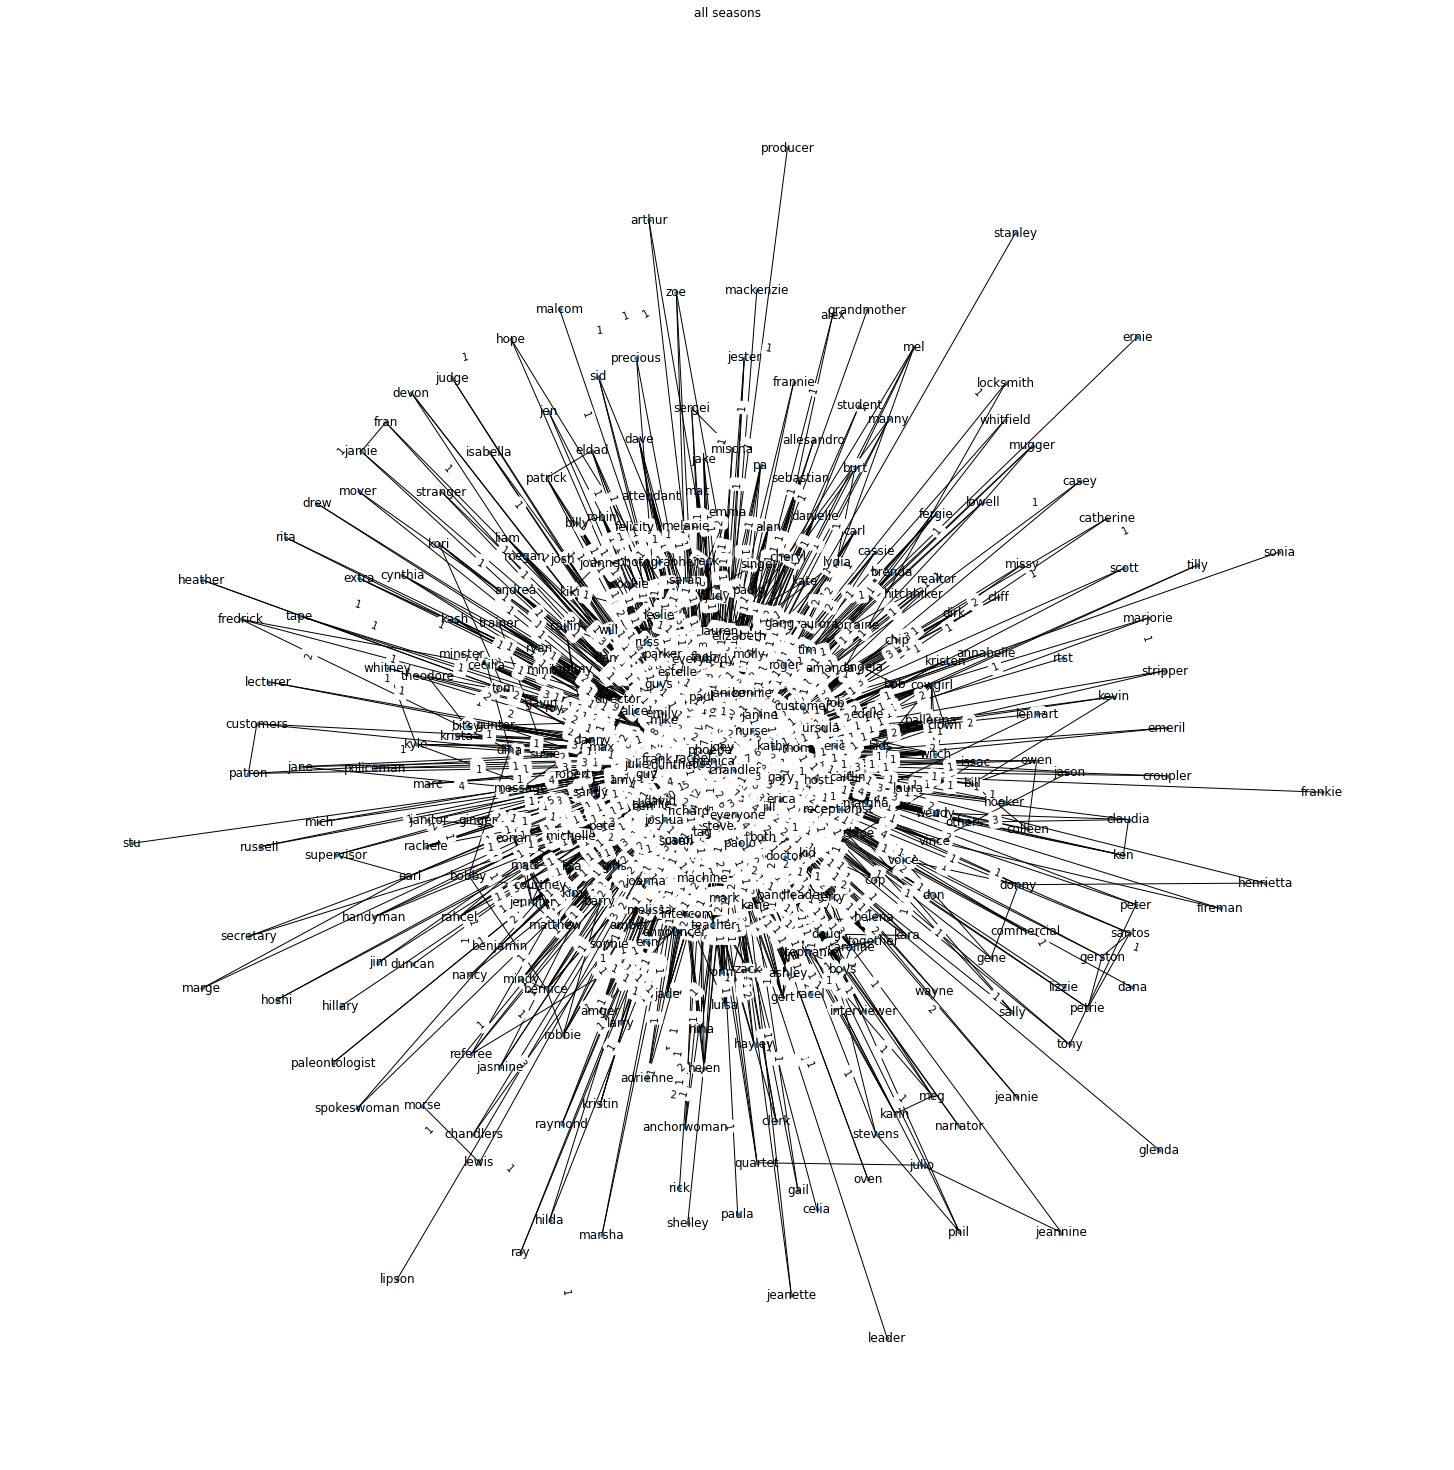

In [12]:
##creates the linkdata dataframe which we use to create the graph with the weight added as each edge's attribute
linkData = pd.DataFrame({'source' : intersection_df['node1'],
                  'target' : intersection_df['node2'],
                  'weight' : intersection_df['weight']})
G_S1 = nx.from_pandas_edgelist(linkData, 'source', 'target', True, nx.Graph())

##removes isolated nodes and random words
G_S1.remove_nodes_from(list(nx.isolates(G_S1)))
random_words_list=['waitress','actor','woman','man','actress','street','waiter','assistant','passenger',
                   'girl','boy','video','tv','radio', 'salesman', 'waiters','housekeeper','dog',
                  'boss','intern','cashier','chandlerdlers','passerby','friend','employee','lady','dream monica','dream joey','all']
G_S1.remove_nodes_from(random_words_list)

##plots the Graph
plt.figure(3,figsize=(20,20)) 
pos=nx.spring_layout(G_S1)
labels = nx.get_edge_attributes(G_S1,'weight')
nx.draw(G_S1,with_labels=True,node_size = 10)
nx.draw_networkx_edge_labels(G_S1,pos,edge_labels=labels)
plt.title('all seasons')

In [13]:
#creates txt file with the edgelist and their weights
nx.write_edgelist(G_S1, "weighted_test_edgelist.txt", delimiter=' ')

In [14]:
G_S1.number_of_nodes()
G_S1.number_of_edges()
print (f'The number of nodes is { G_S1.number_of_nodes()} \nThe number of links is {G_S1.number_of_edges()}')

The number of nodes is 330 
The number of links is 1560


The median of the in degrees is 5


C:\Users\stykaly\AppData\Local\Temp\ipykernel_19880\1781827516.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(len(degree_freq)), degree_freq, 'go-', label='degree', marker='.')


Text(0, 0.5, 'Frequency')

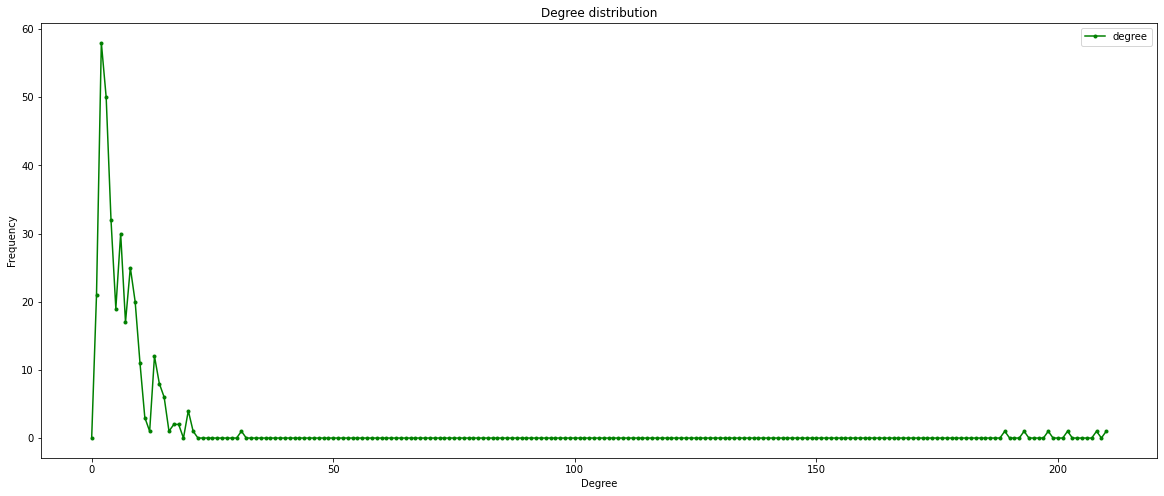

In [15]:
##Finds degree distibution
nodeslist=list(G_S1.nodes())
degrees=list(G_S1.degree(nodeslist))
# Sorts the in-degree matrix from low to high
deg=[]
for i in range (len(degrees)):
    deg.append(degrees[i][1])
list.sort(deg)
print (f'The median of the in degrees is {deg[int(len(deg)/2)]}')

def finds_freq(list1):
    dmax=max(list1)+1
    freq= [ 0 for d in range(dmax) ]
    for d in list1:
        freq[d] += 1
    return freq
degree_freq=finds_freq(deg)



degrees = range(len(degree_freq))
plt.figure(figsize=(20, 8)) 
plt.plot(range(len(degree_freq)), degree_freq, 'go-', label='degree', marker='.') 
plt.title("Degree distribution")
plt.legend(loc="upper right")
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [16]:
   
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)

100%|██████████| 2000/2000 [00:10<00:00, 187.51it/s]


BarnesHut Approximation  took  1.48  seconds
Repulsion forces  took  8.24  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.40  seconds
AdjustSpeedAndApplyForces step  took  0.30  seconds


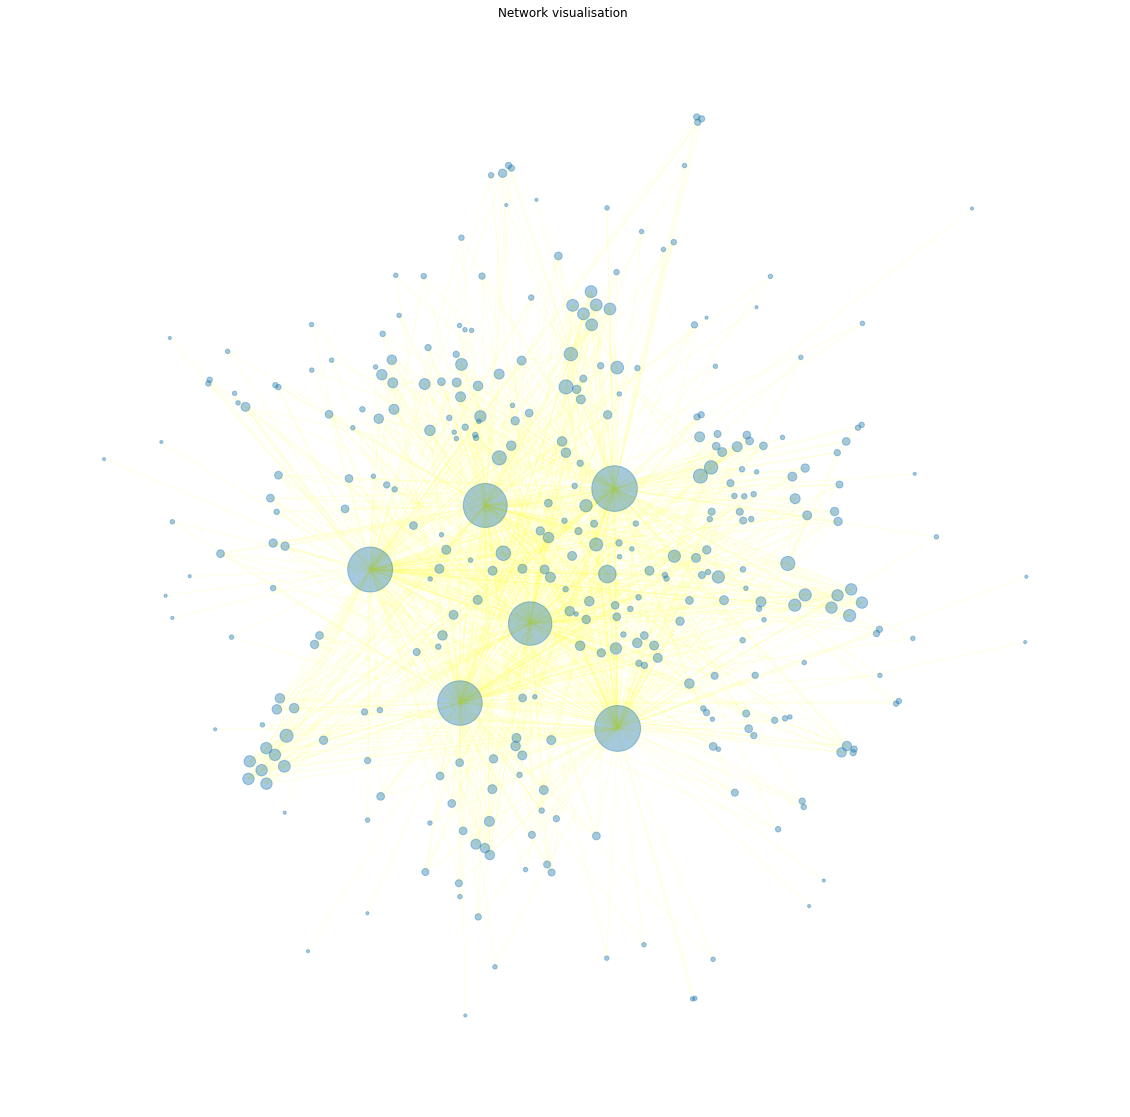

In [25]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.7,

                        # Log
                        verbose=True)

fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_size=custom_size, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title('Network visualisation ')
plt.axis('off')
plt.show()

In [19]:
# First compute the best partition
partition = community.community_louvain.best_partition(G_S1,weight='weight')


size =len(set(partition.values()))

# Find number of communities and print each one's size
print(f'The friends network has {int(size)} communities')

comm_sizes=Counter(partition.values())
community_sizes_list=list(comm_sizes.values())
community_sizes_list.sort()
for i in range (len(community_sizes_list)):
    print(f'Community {i} has size {community_sizes_list[i]}')

# Add 'community' attribute to node 
nx.set_node_attributes(G_S1, partition, name= 'community')

The friends network has 21 communities
Community 0 has size 2
Community 1 has size 2
Community 2 has size 2
Community 3 has size 2
Community 4 has size 2
Community 5 has size 2
Community 6 has size 2
Community 7 has size 3
Community 8 has size 3
Community 9 has size 4
Community 10 has size 4
Community 11 has size 4
Community 12 has size 5
Community 13 has size 6
Community 14 has size 6
Community 15 has size 13
Community 16 has size 24
Community 17 has size 24
Community 18 has size 37
Community 19 has size 47
Community 20 has size 136


In [20]:
color_dictionary={0:'deeppink',
                  1:'purple',
                  2: 'aquamarine',
                  3:'red',
                  4:'blue',
                  5:'orange',
                  6:'coral',
                  7:'green',
                  8:'brown',
                  9:'peachpuff',
                  10:'black',
                  11:'pink',
                  12:'wheat',
                  13:'gray',
                  14:'lightcoral',
                  15:'beige',
                  16:'indigo',
                  17:'lightgreen',
                  18:'indigo',
                  19:'lightgreen',
                  20:'indigo',
                  21:'lightgreen'}

# Creates color list and size list for all the nodes
# Using the 'community' attribute for coloring
community=nx.get_node_attributes(G_S1, 'community')  
nodeslist=list(G_S1.nodes())
custom_color=[]
for i in nodeslist:
    custom_color.append(color_dictionary[community[i]])
    
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# Converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)


100%|██████████| 2000/2000 [00:10<00:00, 184.22it/s]


BarnesHut Approximation  took  1.94  seconds
Repulsion forces  took  7.98  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.29  seconds
AdjustSpeedAndApplyForces step  took  0.27  seconds


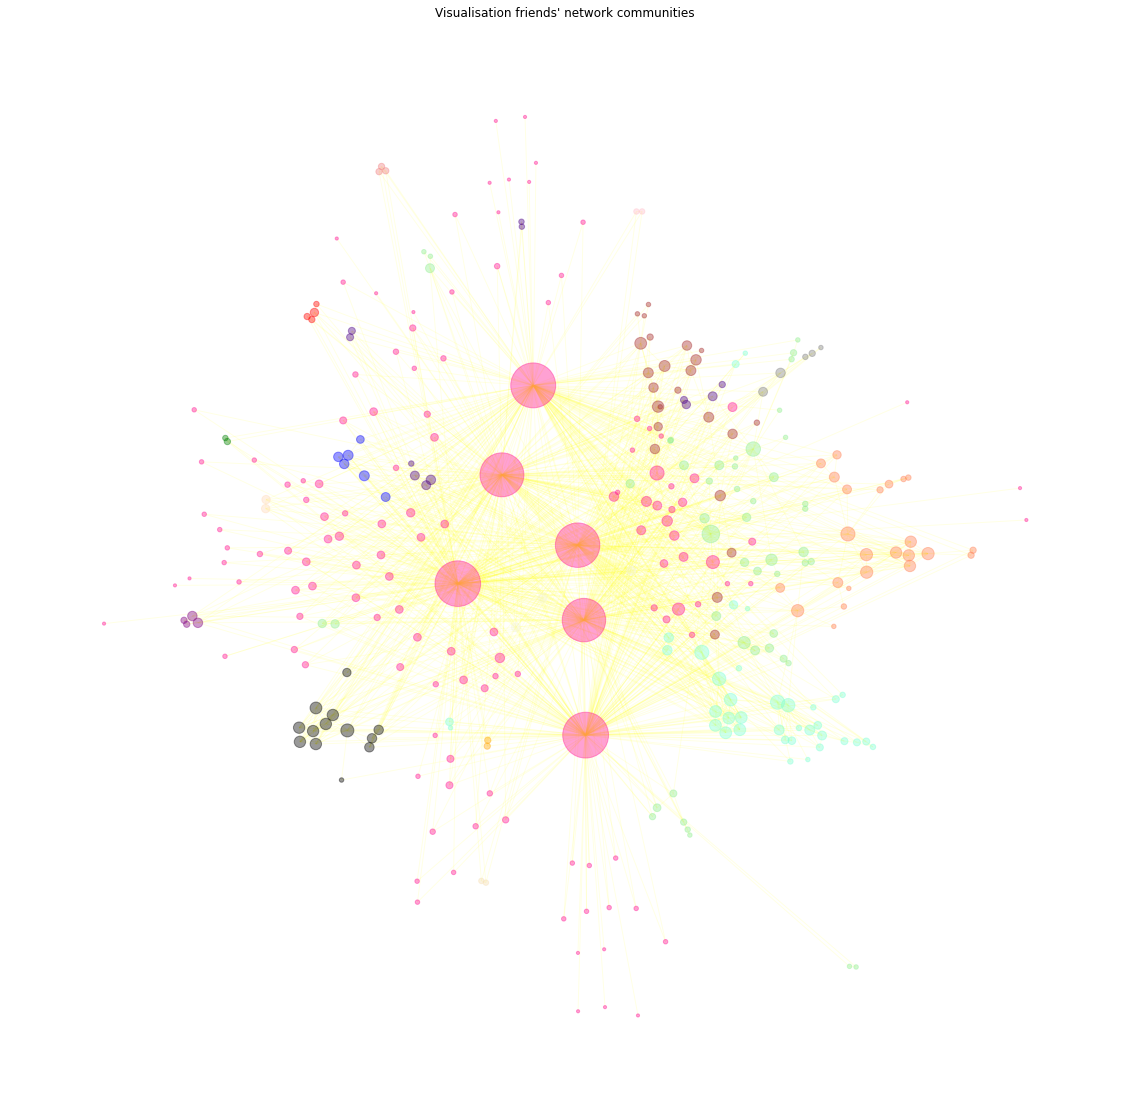

In [21]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=10,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)


fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_color=custom_color, node_size=custom_size, label=nodeslist, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title("Visualisation friends' network communities")
plt.axis('off')
plt.show()